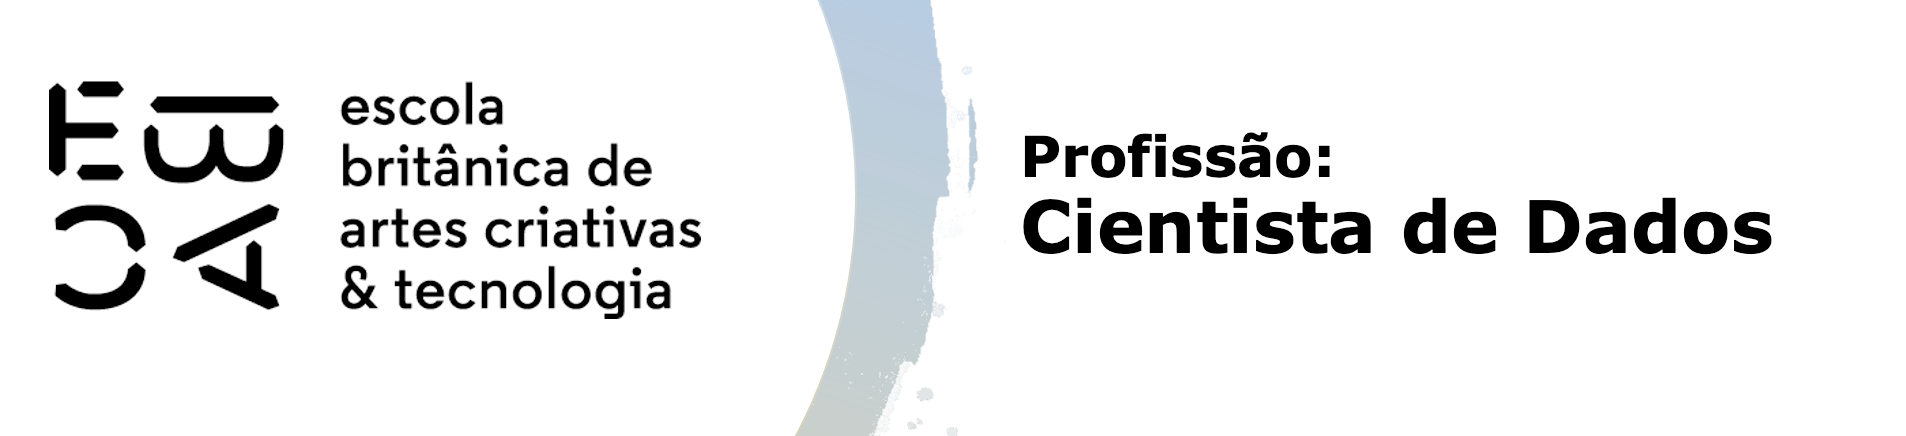

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_pickle('base_nfp.pkl')
df.head()

CNPJ emit.                                           Emitente  \
0  03.476.811/0741-98                      DIA BRASIL SOCIEDADE LIMITADA   
1  43.101.310/0001-05                         AUTO POSTO ZANWAL LTDA EPP   
2  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
3  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   
4  23.750.257/0001-66  OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE   

    No. Data Emissão  Valor NF Data Registro  Créditos Situação do Crédito  \
0   537   2017-06-30     24.68    2017-06-30      0.00            Liberado   
1  2894   2017-06-30     50.00    2017-06-30      0.00            Liberado   
2   699   2017-06-30     27.00    2017-06-30      0.44            Liberado   
3   698   2017-06-30    111.50    2017-06-30      1.81            Liberado   
4   694   2017-06-30    125.00    2017-06-30      2.03            Liberado   

    Ano  Semestre   Retorno  flag_credito     categoria  
0  2017         1  0.000000             0       Mercado  
1  2017         1  0.000000             0    Auto posto  
2  2017         1  0.016296             1  Restaurantes  
3  2017         1  0.016233             1  Restaurantes  
4  2017         1  0.016240             1  Restaurantes

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [4]:
df_recente = df[df['Data Emissão']>='2020-01-01'].copy()

In [11]:
df_recente['retorno_maior'] = [1 if x > 0 else 0 for x in df_recente['Retorno']]

In [25]:
tab = pd.DataFrame(df_recente.groupby(['categoria'])['retorno_maior'].sum())
tab['qtd_registros'] = pd.DataFrame(df_recente.groupby(['categoria'])['Retorno'].count())
tab['proporcao'] = tab['retorno_maior'] / tab['qtd_registros']
tab.sort_values(by=['proporcao'],ascending=False)

retorno_maior  qtd_registros  proporcao
categoria                                            
Restaurantes           1626           2179   0.746214
Alimentos              3442           5050   0.681584
Mercado               13177          27553   0.478242
Construção             7523          16044   0.468898
não definido           6689          18348   0.364563
Farmácia               3582          10189   0.351556
Auto posto              135            540   0.250000
Vestuário               443           1915   0.231332
Varejo                  701           4182   0.167623

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [29]:
tab = pd.crosstab(df_recente.categoria, df_recente.retorno_maior, margins=True, margins_name='total')
tab['bad_rate'] = tab[1]/tab['total']
tab['odds'] = tab[1]/tab[0]
tab['odds_ratio'] = tab['odds']/tab.loc['total', 'odds']
tab['woe'] = np.log(tab.odds_ratio)
tab

retorno_maior      0      1  total  bad_rate      odds  odds_ratio       woe
categoria                                                                   
Alimentos       1608   3442   5050  0.681584  2.140547    2.847218  1.046342
Auto posto       405    135    540  0.250000  0.333333    0.443379 -0.813331
Construção      8524   7523  16047  0.468810  0.882567    1.173934  0.160360
Farmácia        6607   3582  10189  0.351556  0.542152    0.721136 -0.326928
Mercado        14381  13177  27558  0.478155  0.916278    1.218775  0.197846
Restaurantes     553   1626   2179  0.746214  2.940325    3.911032  1.363801
Varejo          4365    701   5066  0.138373  0.160596    0.213614 -1.543585
Vestuário       1477    443   1920  0.230729  0.299932    0.398951 -0.918918
não definido   11718   6689  18407  0.363394  0.570831    0.759283 -0.275381
total          49638  37318  86956  0.429160  0.751803    1.000000  0.000000

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

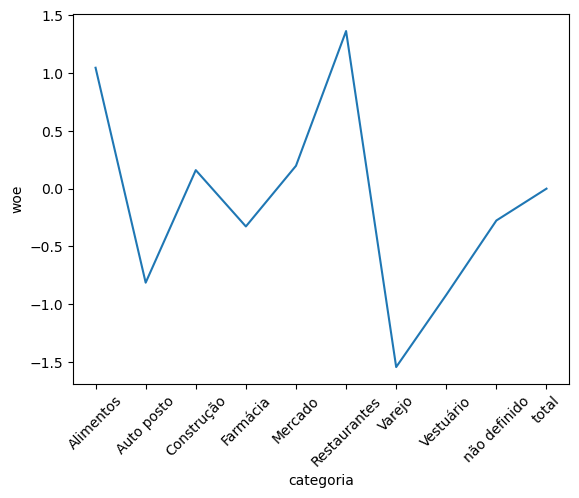

In [34]:
sns.lineplot(data=tab, x="categoria", y="woe")
plt.xticks(rotation=45)

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [39]:
tab = pd.crosstab(df_recente.categoria, df_recente.retorno_maior, margins=True, margins_name='total')
rótulo_evento = tab.columns[0]
rótulo_nao_evento = tab.columns[1]
tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
IV = ((tab.pct_evento - tab.pct_nao_evento)*tab.woe).sum()
print(f'O IV da variável retorno_maior é {IV:.3f}')

O IV da variável retorno_maior é 0.279


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


<font color='blue'>A partir dos resultados acima, temos a importância da variável 'categoria' para a análise em virtude dos WOEs de cada categoria. Já com o IV, percebe-se que é uma variável também relevante quanto ao poder preditivo seguindo a escala de Naeem Siddiqi.</font>